In [1]:
import psycopg2 as pg
import pandas.io.sql as psql
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from nltk.corpus import wordnet as wn

In [2]:
dog = wn.synset('dog.n.01')
dog

Synset('dog.n.01')

In [3]:
dog.hypernyms()

[Synset('canine.n.02'), Synset('domestic_animal.n.01')]

In [4]:
canine = wn.synset('canine.n.02')
canine

Synset('canine.n.02')

In [5]:
canine.hypernyms()

[Synset('carnivore.n.01')]

In [95]:
def closure_graph(synset, fn):
    seen = set()
    graph = nx.DiGraph()
    labels = {}

    def recurse(s):
        if not s in seen:
            seen.add(s)
            graph.add_node(s.name)
            labels[s.name] = s.name().split(".")[0]
            
            for s1 in fn(s):
                graph.add_node(s1.name)
                graph.add_edge(s.name, s1.name)
                recurse(s1)

    recurse(synset)
    
    return graph, labels

In [96]:
graph, labels = closure_graph(dog, lambda s: s.hypernyms())

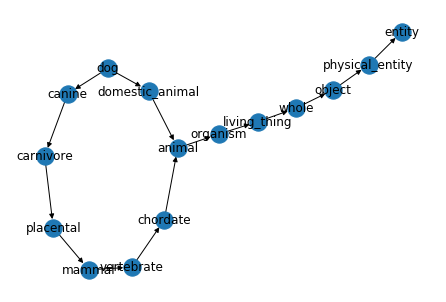

In [97]:
nx.draw(graph, pos=graphviz_layout(graph), labels=labels)

In [98]:
def wordnet_graph(words):
     
    """
    Construct a semantic graph and labels for a set of object categories using 
    WordNet and NetworkX. 

    Parameters: 
    ----------
     words : set
         Set of words for all the categories. 

     Returns: 
     -------
     graph : graph
         Graph object containing edges and nodes for the network. 
     labels : dict
         Dictionary of all synset labels. 
     """
     
    graph = nx.DiGraph()
    labels = {}
    seen = set()

    def recurse(s):

        """ Recursively move up semantic hierarchy and add nodes / edges """  

        if not s in seen:                               # if not seen...
            seen.add(s)                                 # add to seen
            graph.add_node(s.name)                      # add node
            labels[s.name] = s.name().split(".")[0]     # add label
            hypernyms = s.hypernyms()                   # get hypernyms

            for s1 in hypernyms:                        # for hypernyms
                graph.add_node(s1.name)                 # add node
                graph.add_edge(s.name, s1.name)         # add edge between
                recurse(s1)                             # do so until top

    # build network containing all categories          
    for word in words:                                  # for all categories
        s = wn.synset(str(word) + str('.n.01'))         # create synset            
        recurse(s)                                      # call recurse

    # return the graph and labels    
    return graph, labels

In [99]:
# get connected to the database
connection = pg.connect(user='scientist',
                        password='********',
                        host='127.0.01',
                        port='5432',
                        database='tensor_factorisation_wn18')

In [106]:
entity = psql.read_sql("SELECT * FROM entity WHERE pos_tag = 'NN'", connection)
entity.head()

,synset_id,name,pos_tag,sense_index,definition
0,14854262,stool,NN,2,solid excretory product evacuated from the bowels
1,00590383,chieftainship,NN,1,the position of chieftain
2,08769179,saxony,NN,1,an area in Germany around the upper Elbe river...
3,02338145,ondatra zibethica,NN,1,beaver-like aquatic rodent of North America wi...
4,11812094,rose campion,NN,1,an old cottage garden plant of southeastern Eu...


In [107]:
entity_sample = entity.sample(n=10)['name']
entity_sample

28928         grandchild
10141            midriff
25331          spirodela
22350              boost
31144           mackerel
8333                loft
7643          undertaker
21198            servant
19153       undersurface
14748    genus ailanthus
Name: name, dtype: object

In [108]:
categories = set()
for sample in entity_sample:
    name = '_'.join(sample.split())
    print(name)
    categories.add(name)

grandchild
midriff
spirodela
boost
mackerel
loft
undertaker
servant
undersurface
genus_ailanthus


In [110]:
# create the graph and labels
graph, labels = wordnet_graph(categories)
 
print(f'labels: {labels}')

labels: {<bound method Synset.name of Synset('genus_ailanthus.n.01')>: 'genus_ailanthus', <bound method Synset.name of Synset('rosid_dicot_genus.n.01')>: 'rosid_dicot_genus', <bound method Synset.name of Synset('dicot_genus.n.01')>: 'dicot_genus', <bound method Synset.name of Synset('genus.n.02')>: 'genus', <bound method Synset.name of Synset('taxonomic_group.n.01')>: 'taxonomic_group', <bound method Synset.name of Synset('biological_group.n.01')>: 'biological_group', <bound method Synset.name of Synset('group.n.01')>: 'group', <bound method Synset.name of Synset('abstraction.n.06')>: 'abstraction', <bound method Synset.name of Synset('entity.n.01')>: 'entity', <bound method Synset.name of Synset('mortician.n.01')>: 'mortician', <bound method Synset.name of Synset('skilled_worker.n.01')>: 'skilled_worker', <bound method Synset.name of Synset('worker.n.01')>: 'worker', <bound method Synset.name of Synset('person.n.01')>: 'person', <bound method Synset.name of Synset('causal_agent.n.01')

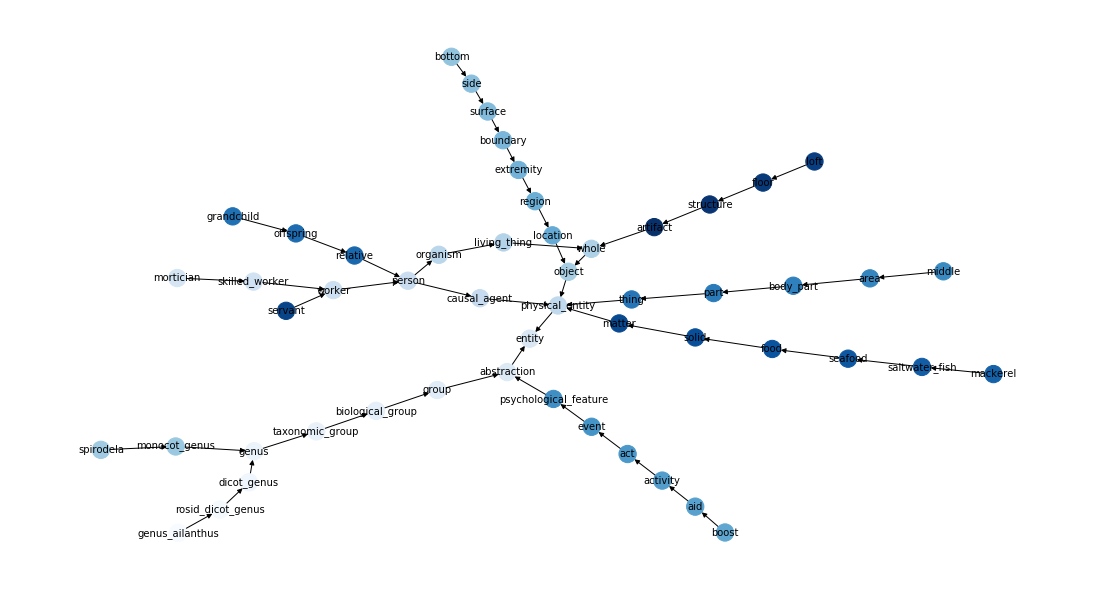

In [111]:
plt.figure(figsize=(15, 8))
# draw the graph
pos=graphviz_layout(graph)
# nx.draw_networkx_labels(graph, pos=pos, labels=labels)
nx.draw(graph, 
        pos=graphviz_layout(graph), 
        labels=labels,
        font_size=10,
        cmap=plt.cm.Blues,
        node_color=range(len(graph)),
        prog='dot')
plt.savefig('WN18.png', format='PNG')
plt.show()